In [1]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


x_train_text = pd.read_csv('data/t2e/text_train.csv')
x_test_text = pd.read_csv('data/t2e/text_test.csv')

y_train_text = x_train_text['label']
y_test_text = x_test_text['label']

x_train_audio = pd.read_csv('data/s2e/audio_train.csv')
x_test_audio = pd.read_csv('data/s2e/audio_test.csv')


y_train_audio = x_train_audio['label']
y_test_audio = x_test_audio['label']

y_train = y_train_audio  # since y_train_audio == y_train_text
y_test = y_test_audio  # since y_train_audio == y_train_text

print(x_train_text.shape, y_train_text.shape, x_train_audio.shape, y_train_audio.shape)

(1609, 3) (1609,) (1609, 10) (1609,)


In [2]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

id_to_emotion = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [5]:
cl_weight = dict(pd.Series(x_train_audio['label']).value_counts(normalize=True))

## Get Text Features

In [6]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features_text = tfidf.fit_transform(x_train_text.append(x_test_text).transcription).toarray()

x_train_text = features_text[:x_train_text.shape[0]]
x_test_text = features_text[-x_test_text.shape[0]:]

print(features_text.shape, x_train_text.shape, x_test_text.shape)

(2012, 328) (1609, 328) (403, 328)


## Combine Text + Audio Features

In [8]:
combined_x_train = np.concatenate((np.array(x_train_audio[x_train_audio.columns[2:]]), x_train_text), axis=1)
combined_x_test = np.concatenate((np.array(x_test_audio[x_test_audio.columns[2:]]), x_test_text), axis=1)

print(combined_x_train.shape, combined_x_test.shape)

combined_features_dict = {}

combined_features_dict['x_train'] = combined_x_train
combined_features_dict['x_test'] = combined_x_test
combined_features_dict['y_train'] = np.array(y_train)
combined_features_dict['y_test'] = np.array(y_test)

with open('data/combined/combined_features.pkl', 'wb') as f:
    pickle.dump(combined_features_dict, f)

(1609, 336) (403, 336)


Test Set Accuracy =  0.638
Test Set F-score =  0.627
Test Set Precision =  0.646
Test Set Recall =  0.631
Confusion matrix, without normalization
[[13  8 11  0  1  3]
 [11 22 18  0  0 15]
 [ 8  1 61  0  3 20]
 [ 0  0  0 65  0  0]
 [ 0  0  0  0 60  0]
 [ 3  3 38  1  2 36]]


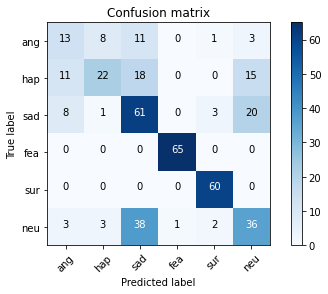

In [15]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/combined/RF.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

Test Set Accuracy =  0.615
Test Set F-score =  0.613
Test Set Precision =  0.615
Test Set Recall =  0.619
Confusion matrix, without normalization
[[14  8  8  1  1  4]
 [10 26 18  0  0 12]
 [ 8  2 52  3  0 28]
 [ 0  0  0 65  0  0]
 [ 0  0  0  0 60  0]
 [ 6 10 32  2  2 31]]


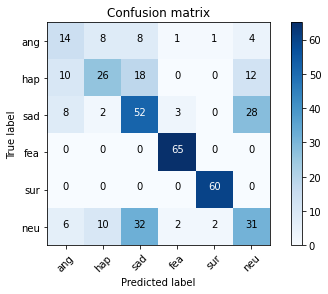

In [16]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/combined/XGB.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

Test Set Accuracy =  0.596
Test Set F-score =  0.604
Test Set Precision =  0.630
Test Set Recall =  0.598
Confusion matrix, without normalization
[[16  2  8  0  1  9]
 [ 8 26 13  4  0 15]
 [ 8  5 44  8  0 28]
 [ 0  0  0 56  0  9]
 [ 0  0  0  2 51  7]
 [ 6  5 24  1  0 47]]


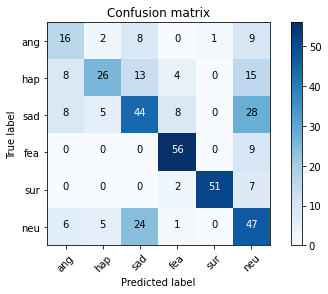

In [17]:
svc_classifier = LinearSVC()

svc_classifier.fit(combined_x_train, y_train)

# Predict
pred = svc_classifier.predict(combined_x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)
(y_test, pred_probs)

with open('pred_probas/combined_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)
    
with open('trained_models/combined/SVC.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.568
Test Set F-score =  0.569
Test Set Precision =  0.624
Test Set Recall =  0.556
Confusion matrix, without normalization
[[11  3 14  0  1  7]
 [ 5 22 22  4  1 12]
 [ 4  4 59  6  1 19]
 [ 0  0  9 56  0  0]
 [ 0  0  6  2 49  3]
 [ 2  3 43  3  0 32]]


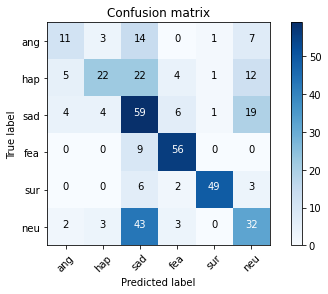

In [18]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/combined/MNB.pkl', 'wb') as f:
    pickle.dump(mnb_classifier, f)

Test Set Accuracy =  0.675
Test Set F-score =  0.670
Test Set Precision =  0.670
Test Set Recall =  0.675
Confusion matrix, without normalization
[[15  2 11  0  0  8]
 [ 7 36 10  1  1 11]
 [ 7  8 51  3  3 21]
 [ 0  0  0 65  0  0]
 [ 0  0  0  0 60  0]
 [ 4  7 22  0  5 45]]


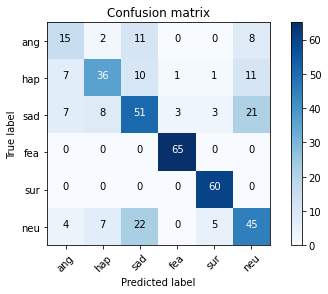

In [20]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/combined/MLP.pkl', 'wb') as f:
    pickle.dump(mlp_classifier, f)

Test Set Accuracy =  0.561
Test Set F-score =  0.568
Test Set Precision =  0.616
Test Set Recall =  0.558
Confusion matrix, without normalization
[[13  2  8  0  1 12]
 [ 4 20 24  4  1 13]
 [ 6  1 49  9  1 27]
 [ 0  0  5 56  0  4]
 [ 0  0  4  2 51  3]
 [ 5  4 35  2  0 37]]


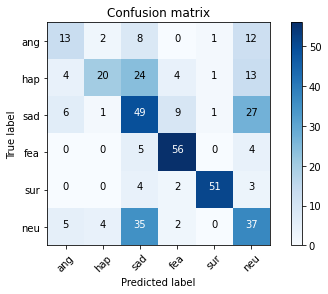

In [21]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/combined/LR.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

[6.01546327e-03 8.14984553e-03 1.11883115e-02 7.44683901e-03
 8.06877669e-03 5.43422205e-03 6.00168575e-03 7.60995829e-03
 5.80966240e-03 3.15447059e-03 2.25161761e-03 0.00000000e+00
 0.00000000e+00 3.43261915e-03 3.33716045e-03 4.75127297e-03
 2.56813015e-03 0.00000000e+00 1.21345865e-02 3.78787778e-02
 1.41802104e-02 0.00000000e+00 2.53731245e-03 0.00000000e+00
 1.62769035e-02 4.86897212e-03 0.00000000e+00 0.00000000e+00
 3.55334952e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.69932337e-02 0.00000000e+00 1.18753016e-02 0.00000000e+00
 3.44663486e-03 2.29881424e-03 0.00000000e+00 6.50676293e-03
 3.15432763e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.82010802e-03 3.39869759e-03 5.87538956e-03 0.00000000e+00
 3.03464360e-03 0.00000000e+00 3.17670545e-03 4.79830289e-03
 4.23199963e-03 8.00883323e-02 2.36943504e-03 0.00000000e+00
 3.80007154e-03 0.00000000e+00 1.33386650e-03 0.00000000e+00
 1.71133154e-03 1.54618742e-02 0.00000000e+00 0.00000000e+00
 1.79760717e-03 2.481858

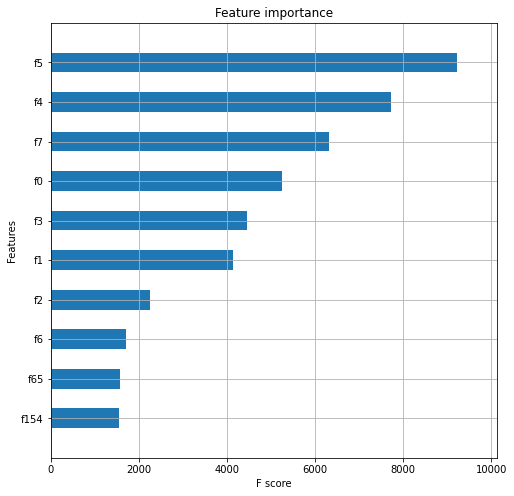

In [22]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
contribution_scores = xgb_classifier.feature_importances_
print(contribution_scores)

In [23]:
# Load predicted probabilities
with open('pred_probas/combined_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/combined_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/combined_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/combined_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/combined_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/combined_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

with open('pred_probas/combined_lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0
# Show metrics
display_results(y_test, ensemble_pred_probs)

FileNotFoundError: [Errno 2] No such file or directory: 'pred_probas/combined_lstm_classifier.pkl'